# Analysis of MRI Data of Alzheimer's Disease

### Analysis completed by Grant Foster

These two data sets are from The Open Access Series of Imaging Studies (OASIS) and look at both dementia and Alzheimer's Disease. The cross-section study looks at 416 participants on a single visit, and includes 20 non-demented participants for reliability. The longitudinal study looks at 150 particpants with developing, or possibly developing, dementia, over two or more visits. Both studies used T1-wieghted MRI scans. 

I will focus on the longitudinal study to analyze how brain structure and behaviour changes over the course of a few years. My aim is to see how brain volume deterioates differently with dementia as oppposed to regular aging. 

In [79]:
import numpy as np
import pandas as pd
import sys
from scipy import stats

import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (6, 6)

In [125]:
mri=pd.read_csv("data/mri_and_alzheimers/oasis_longitudinal.csv")

In [126]:
mri.shape

(373, 15)

In [127]:
mri.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [128]:
mri = mri.rename(columns={
    # "original":"new_name"
    "Subject ID":"Subject_ID",
    "MRI ID":"MRI_ID",
    "MR Delay":"MR_Delay",
    "M/F":"Gender",
    "EDUC":"Education",
    "SES":"SocEco", # Socio-Economic status
    "MMSE":"Mental_State", # Mini Mental State Examination
    "eTIV":"ICV", # Estimated Total Intracranial Volume
    "nWBV":"WBV", # Normalize Whole Brain Volume
    "ASF":"Atlas" # Atlas Scaling Factor
})

In [120]:
mri.dtypes

Subject_ID            object
MRI_ID                object
Group                 object
Visit                  int64
MR_Delay               int64
Gender                object
Hand                  object
Age                    int64
Education              int64
SocEco               float64
Mental_State         float64
Clinical_Dementia    float64
ICV                    int64
WBV                  float64
Atlas                float64
dtype: object

In [121]:
mri.describe()

,Visit,MR_Delay,Age,Education,SocEco,Mental_State,Clinical_Dementia,ICV,WBV,Atlas
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


### Definition of Columns

- Group: Classified as 'Demented' or 'Not demented' during that visit
- Visit: First, Second, Third, etc. time the patient was recorded. At least one year was needed between visits
- MR_Delay:
- Gender:
- Hand: 
- Age: The age at the time of visit
- Education: 
- SocEco:
- Mental_State:
- CDR: Clinical Dementia Report.
- ICV: Intracranial Volume. 
- WBV: Whole Brain Volume.
- Atlas: The value the ICV has to be scaled by to fit a brain atlas (aka. brain model)

# Checking for repeat participants

In [85]:
mri['unique_participant']=mri.Subject_ID.str.cat(
    [mri.Subject_ID, mri.Visit.apply(str), mri.Age.apply(str)],sep='-')

In [86]:
mri[['Subject_ID','Age','Clinical_Dementia','unique_participant']].head()

,Subject_ID,Age,Clinical_Dementia,unique_participant
0,OAS2_0001,87,0.0,OAS2_0001-OAS2_0001-1-87
1,OAS2_0001,88,0.0,OAS2_0001-OAS2_0001-2-88
2,OAS2_0002,75,0.5,OAS2_0002-OAS2_0002-1-75
3,OAS2_0002,76,0.5,OAS2_0002-OAS2_0002-2-76
4,OAS2_0002,80,0.5,OAS2_0002-OAS2_0002-3-80


In [87]:
# mri.unique_participant.value_counts()

In [88]:
mri[mri.duplicated()].shape

(0, 16)

There are no repeated participant visits. 

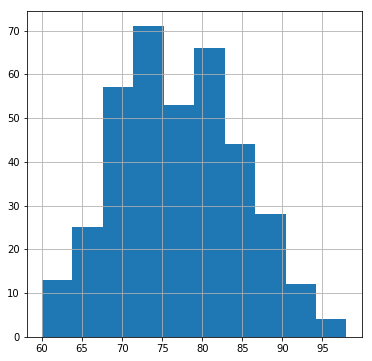

In [89]:
mri.Age.hist();

In [90]:
n_records = len(mri)
def missing_values_df(df):
    for column in df:
        print("{} | {} | {}".format(
            column, len(df[df[column].isnull()]) / (1.0*n_records), df[column].dtype
        ))

missing_values_df(mri)

Subject_ID | 0.0 | object
MRI_ID | 0.0 | object
Group | 0.0 | object
Visit | 0.0 | int64
MR_Delay | 0.0 | int64
Gender | 0.0 | object
Hand | 0.0 | object
Age | 0.0 | int64
Education | 0.0 | int64
SocEco | 0.05093833780160858 | float64
Mental_State | 0.005361930294906166 | float64
Clinical_Dementia | 0.0 | float64
ICV | 0.0 | int64
WBV | 0.0 | float64
Atlas | 0.0 | float64
unique_participant | 0.0 | object


50% of participants are missing Socio-economic status.

0.5% of participants are missing mini mental state examination.

In [91]:
column = "WBV"
print(f"the average {column} score is {mri[column].mean()}")
# consider outliers those observations with a z score greater than 2
mri[(np.abs(stats.zscore(mri[column])) > 3)].shape

the average WBV score is 0.7295683646112608


(0, 16)

In [95]:
column = "ICV"
print(f"the average {column} score is {mri[column].mean()}")
# consider outliers those observations with a z score greater than 2
mri[(np.abs(stats.zscore(mri[column])) > 3)].shape

the average ICV score is 1488.1286863270777


(0, 16)

In [94]:
column = "Atlas"
print(f"the average {column} score is {mri[column].mean()}")
# consider outliers those observations with a z score greater than 2
mri[(np.abs(stats.zscore(mri[column])) > 3)].shape

the average Atlas score is 1.1954611260053603


(0, 16)

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
mri_decline = mri.query("Age")

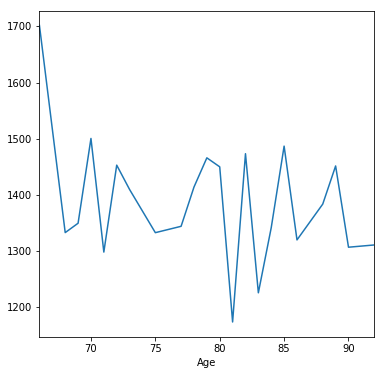

In [99]:
mri.query("Age").groupby('Age')['ICV'].mean().plot();

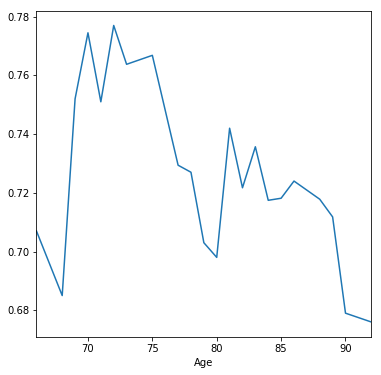

In [100]:
mri.query("Age").groupby('Age')['WBV'].mean().plot();

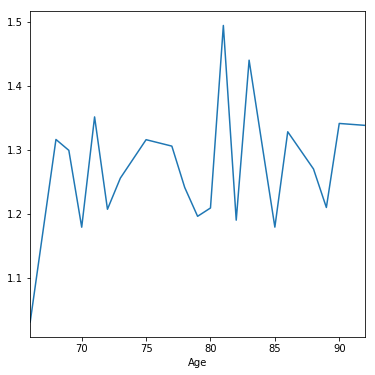

In [101]:
mri.query("Age").groupby('Age')['Atlas'].mean().plot();

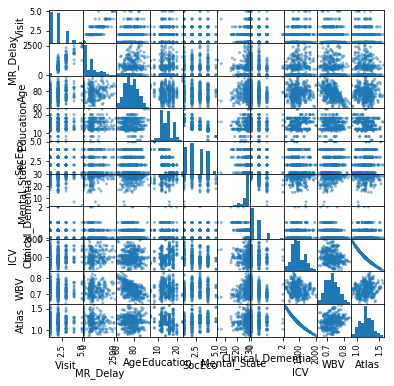

In [103]:
pd.plotting.scatter_matrix(mri.select_dtypes(include=[np.number]));

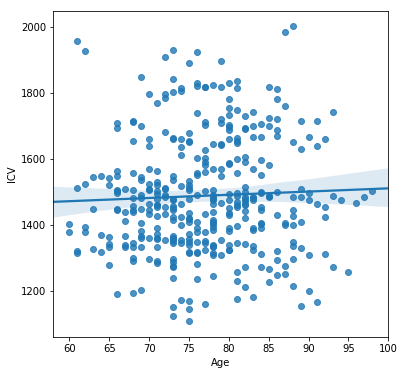

In [107]:
sns.regplot("Age", "ICV", data=mri);

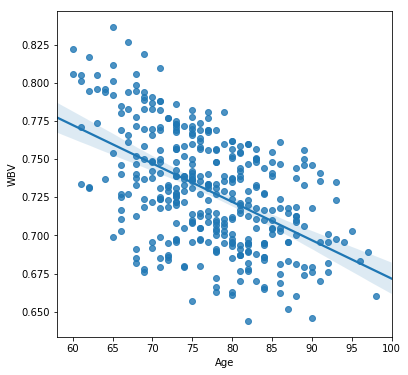

In [106]:
sns.regplot("Age", "WBV", data=mri);

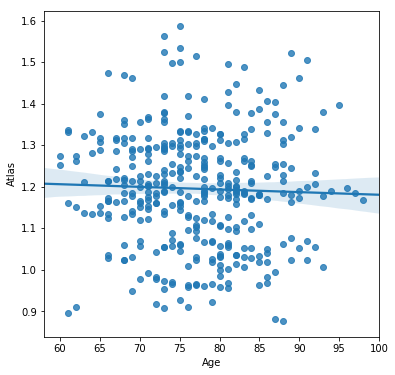

In [108]:
sns.regplot("Age", "Atlas", data=mri);

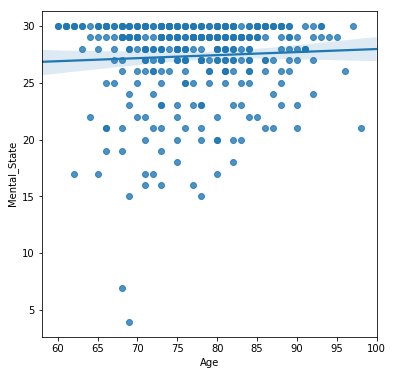

In [111]:
sns.regplot("Age", "Mental_State", data=mri);

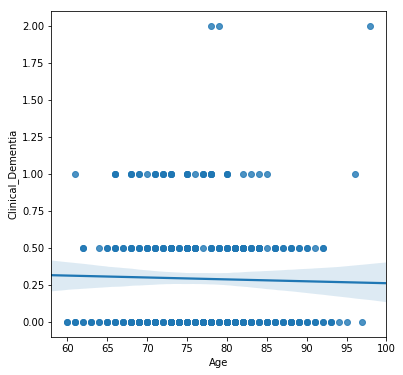

In [114]:
sns.regplot("Age", "Clinical_Dementia", data=mri);

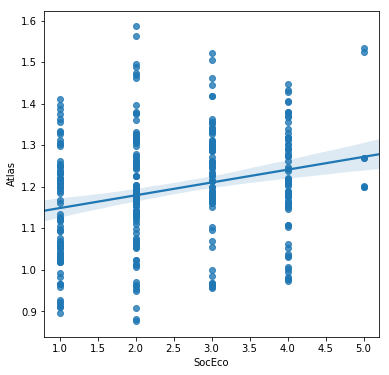

In [124]:
sns.regplot("SocEco", "Atlas", data=mri);